### Confirming our test results


In [2]:
import pandas as pd
ab_test_results = pd.read_csv('/Users/xingkaiwu/Library/CloudStorage/OneDrive-YorkUniversity/MBAN Winter/MBAN 6400/Customer Analytics and AB Testing in Python/AB_testing_exercise.csv')

In [4]:
# Compute and print the results
results = ab_test_results.groupby('group').agg({'uid':pd.Series.nunique}) 
# Find the unique users in each group 
results = ab_test_results.groupby('group').agg({'uid': pd.Series.nunique}) 

# Find the overall number of unique users using "len" and "unique"
unique_users = len(ab_test_results.uid.unique()) 

# Find the percentage in each group
results = results / unique_users * 100
print(results)

             uid
group           
GRP A  50.147113
GRP B  49.852887


In [6]:
# Find the unique users in each group, by device and gender
results = ab_test_results.groupby(by=['group', 'device', 'gender']).agg({'uid': pd.Series.nunique}) 

# Find the overall number of unique users using "len" and "unique"
unique_users = len(ab_test_results.uid.unique())

# Find the percentage in each group
results = results / unique_users * 100
print(results)

                           uid
group device gender           
GRP A A      F       12.239827
             M       12.795589
      I      F       12.542772
             M       12.568925
GRP B A      F       12.553669
             M       12.499183
      I      F       12.283417
             M       12.516618


### Thinking critically about p-values

The p-value is the probability of observing a value as or more extreme than the one observed under the Null Hypothesis.

### What is Confidence Interval

Specifically, if we provide a 95% confidence interval we are saying that if we had a series of independent experiments and for each estimated an unrelated parameter and a 95% confidence interval, then 95% of the intervals will contain the true parameter. The important thing to note is that the parameters, such as the true conversion rate, are not random, it is the interval that is random.

### Intuition behind statistical significance


In [7]:
from scipy import stats
def get_power(n, p1, p2, cl):
    alpha = 1 - cl
    
    qu = stats.norm.ppf(1 - alpha/2)
    
    diff = abs(p2 - p1)
    bp = (p1 + p2) / 2
    
    v1 = p1 * (1 - p1)
    v2 = p2 * (1 - p2)
    
    bv = bp * (1 - bp)
    
    power_part_one = stats.norm.cdf((n**0.5 * diff - qu * (2 * bv)**0.5)/ (v1 + v2)**0.5)
    power_part_two = 1 - stats.norm.cdf((n**0.5 * diff + qu * (2 * bv)**0.5)/ (v1 + v2)**0.5)
    
    power = power_part_one + power_part_two
    return(power)

In [8]:
def get_pvalue(con_conv, test_conv, con_size, test_size):  
    lift =  - abs(test_conv - con_conv)

    scale_one = con_conv * (1 - con_conv) * (1 / con_size)
    scale_two = test_conv * (1 - test_conv) * (1 / test_size)
    scale_val = (scale_one + scale_two)**0.5

    p_value = 2 * stats.norm.cdf(lift, loc = 0, scale = scale_val )

    return p_value

In [9]:
# Get the p-value
p_value = get_pvalue(con_conv=0.1, test_conv=0.17, con_size=1000, test_size=1000)
print(p_value)

4.131297741047306e-06


In [10]:
# Get the p-value
p_value = get_pvalue(con_conv=0.1, test_conv=0.15, con_size=100, test_size=100)
print(p_value)

0.28366948940702086


In [11]:
# Get the p-value
p_value = get_pvalue(con_conv=0.48, test_conv=0.5, con_size=1000, test_size=1000)
print(p_value)

0.370901935824383


### Checking for statistical significance


In [12]:
cont_conv = 0.09096495570387314
test_conv= 0.1020053238686779
cont_size = 5329
test_size = 5748
# Compute the p-value
p_value = get_pvalue(con_conv=cont_conv, test_conv=test_conv, con_size=cont_size, test_size=test_size)
print(p_value)

# Check for statistical significance
if p_value >= 0.05:
    print("Not Significant")
else:
    print("Significant Result")

0.04900185792087508
Significant Result


### Understanding confidence intervals


In [13]:
def get_ci(value, cl, sd):
    loc = stats.norm.ppf(1 - cl/2)
    rng_val = stats.norm.cdf(loc - value/sd)

    lwr_bnd = value - rng_val
    upr_bnd = value + rng_val 

    return_val = (lwr_bnd, upr_bnd)
    return(return_val)

In [14]:
# Compute and print the confidence interval
confidence_interval  = get_ci(1, 0.975, 0.5)
print(confidence_interval)

(0.9755040421682947, 1.0244959578317054)


In [15]:
# Compute and print the confidence interval
confidence_interval  = get_ci(1, 0.95, 2)
print(confidence_interval)

(0.6690506448818785, 1.3309493551181215)


In [16]:
# Compute and print the confidence interval
confidence_interval  = get_ci(1, 0.95, 0.001)
print(confidence_interval)

(1.0, 1.0)


As our standard deviation decreases so too does the width of our confidence interval. 

### Calculating confidence intervals


In [18]:
cont_conv = 0.090965
test_conv = 0.102005
cont_size = 58583
test_size = 56350

# Calculate the mean of our lift distribution 
lift_mean = test_conv - cont_conv 

# Calculate variance and standard deviation 
lift_variance = (1 - test_conv) * test_conv /test_size + (1 - cont_conv) * cont_conv / cont_size
lift_sd = lift_variance**0.5

# Find the confidence intervals with cl = 0.95
confidence_interval = get_ci(lift_mean, 0.95, lift_sd)
print(confidence_interval)

(0.011039999822042502, 0.011040000177957487)


### Interpreting your test result

The first step is deciding on what data to report. Typically, you will want to share the following, when presenting results. 

1 - The sample size for each group. 

2 - How long the test ran. 

3 - The mean and variance of your two groups, as well as the estimated lift and confidence intervals. These can be presented nicely in a table as the above example from another A/B test illustrates 

4 - Finally, you want to provide some indication of whether or not the result was statistically significant.

### Plotting the distribution


In [26]:
cont_var = cont_conv*(1-cont_conv)/cont_size
test_var = test_conv*(1-test_conv)/test_size

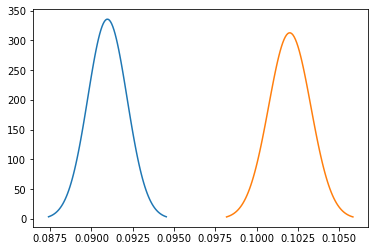

In [30]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

# Compute the standard deviations
control_sd = cont_var**0.5
test_sd = test_var**0.5

# Create the range of x values 
control_line = np.linspace( cont_conv - 3 * control_sd, cont_conv + 3 * control_sd , 100)
test_line = np.linspace( test_conv - 3 * test_sd,  test_conv + 3 * test_sd , 100)

# Plot the distribution 
plt.plot(control_line, norm.pdf(control_line, cont_conv, cont_var**0.5))
plt.plot(test_line, norm.pdf(test_line,test_conv, test_var**0.5))
plt.show()

### Plotting the difference distribution


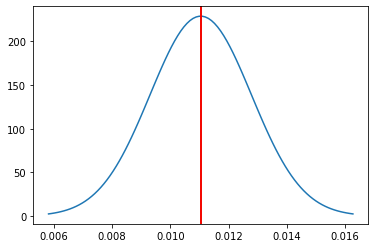

In [33]:
# Find the lift mean and standard deviation
lift_mean = test_conv - cont_conv
lift_sd = (test_var + cont_var) ** 0.5

confidence_interval  = get_ci(lift_mean, 0.95, lift_sd)
lwr_ci = confidence_interval[0]
upr_ci = confidence_interval[1]
# Generate the range of x-values
lift_line = np.linspace(lift_mean - 3 * lift_sd, lift_mean + 3 * lift_sd, 100)

# Plot the lift distribution
plt.plot(lift_line, norm.pdf(lift_line, lift_mean, lift_sd))

# Add the annotation lines
plt.axvline(x = lift_mean, color = 'green')
plt.axvline(x = lwr_ci, color = 'red')
plt.axvline(x = upr_ci, color = 'red')
plt.show()